In [1]:
#!pip install emoji --upgrade

In [2]:
#!pip install xgboost

In [3]:
#!pip install shap

In [4]:
import os 
import re

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_validate

In [7]:
from xgboost import XGBRegressor

In [8]:
import shap
shap.initjs()

/home/gabymhuidobro/.pyenv/versions/3.10.6/envs/le-wagon-rus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATASETS | data_ruscdmx (data_RUS*)

In [9]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

## AGEB | formato shape | agebs

In [10]:
ageb_rural =gpd.read_file('../raw_data/poligono_ageb_rurales_cdmx/poligono_ageb_rurales_cdmx.shp')

In [11]:
ageb_urbana =gpd.read_file('../raw_data/poligono_ageb_urbanas_cdmx/poligono_ageb_urbanas_cdmx.shp')

In [12]:
agebs = pd.concat([ageb_rural, ageb_urbana])

In [13]:
agebs = agebs.drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_AGEB','CVE_LOC'])

In [14]:
agebs.shape

(2453, 2)

## Dataset features | data_RUS

In [15]:
data_RUS = pd.read_csv('../clean_datasets/data_RUS.csv')

In [16]:
data_RUS.drop(columns='Unnamed: 0', inplace=True)

In [17]:
data_RUS.columns

Index(['CVEGEO', 'RECUCALL_C_1', 'RAMPAS_C_1', 'PASOPEAT_C_1', 'BANQUETA_C_1',
       'CICLOVIA_C_1', 'ALUMPUB_C_1', 'ARBOLES_C_1', 'SEMAPEAT_C_1',
       'DRENAJEP_C_1', 'ACESOPER_C_1', 'PUESSEMI_C_1', 'PUESAMBU_C_1',
       'salud_count', 'com_comidas', 'deportivos_count',
       'infraestructura_count', 'comercios_count', 'educacion_count',
       'pp_count', 'guarderias', 'transporte', 'P5_HLI', 'POB_AFRO',
       'PCON_DISC', 'PEA', 'POBREZA', 'GRAPROES', 'POBREZAEX', 'vio_index'],
      dtype='object')

In [18]:
data_RUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CVEGEO                 2453 non-null   object 
 1   RECUCALL_C_1           2453 non-null   float64
 2   RAMPAS_C_1             2453 non-null   float64
 3   PASOPEAT_C_1           2453 non-null   float64
 4   BANQUETA_C_1           2453 non-null   float64
 5   CICLOVIA_C_1           2453 non-null   float64
 6   ALUMPUB_C_1            2453 non-null   float64
 7   ARBOLES_C_1            2453 non-null   float64
 8   SEMAPEAT_C_1           2453 non-null   float64
 9   DRENAJEP_C_1           2453 non-null   float64
 10  ACESOPER_C_1           2453 non-null   float64
 11  PUESSEMI_C_1           2453 non-null   float64
 12  PUESAMBU_C_1           2453 non-null   float64
 13  salud_count            2453 non-null   float64
 14  com_comidas            2453 non-null   float64
 15  depo

In [19]:
data_ruscdmx = pd.merge(agebs, data_RUS,how= 'left', on=['CVEGEO'])

In [20]:
data_ruscdmx.shape

(2453, 31)

In [21]:
#list of features
transport_features = ['Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP','Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus']

population_features = [ 'POBTOT_y', 'POBFEM', 'POBMAS', 
                       'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 
                       'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 
                       'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 
                       'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 
                       'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 
                       'PHOG_IND', 'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 
                       'PCON_DISC', 
                       'GRAPROES', 'GRAPROES_F', 'GRAPROES_M', 
                       'PEA', 'PEA_F', 'PEA_M', 
                       'HOGJEF_F', 'HOGJEF_M', 
                       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 
                       'POBREZA', 'POBREZAEX']

urbaninfra_features = ['VIVTOT', 
                       'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 
                       'RAMPAS_C_1', 'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 
                       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8', 'PASOPEAT_C_9', 
                       'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 
                       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8', 'GUARNICI_C_9', 
                       'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 
                       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9', 
                       'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9', 
                       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9', 
                       'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9', 
                       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 
                       'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 
                       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9', 
                       'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9', 
                       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9', 
                       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9', 
                       'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9', 
                       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9']

#we are using only 30 
commerce_features = ['Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares', 
             'Comercio al por menor de artículos de papelería', 'Comercio al por menor de artículos para la limpieza', 
             'Comercio al por menor de carne de aves', 'Comercio al por menor de carnes rojas', 
             'Comercio al por menor de dulces y materias primas para repostería', 'Comercio al por menor de frutas y verduras frescas', 
             'Comercio al por menor de leche, otros productos lácteos y embutidos', 'Comercio al por menor de otros alimentos', 
             'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones', 
             'Comercio al por menor de plantas y flores naturales', 'Comercio al por menor de regalos',
             'Comercio al por menor de ropa, excepto de bebé y lencería', 'Comercio al por menor de teléfonos y otros aparatos de comunicación', 
             'Comercio al por menor en ferreterías y tlapalerías', 'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas', 
             'Consultorios dentales del sector privado', 'Elaboración de tortillas de maíz y molienda de nixtamal', 'Farmacias sin minisúper', 
             'Lavanderías y tintorerías', 'Panificación tradicional', 'Reparación mecánica en general de automóviles y camiones', 
             'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida', 
             'Restaurantes con servicio de preparación de antojitos', 
             'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar', 
             'Restaurantes con servicio de preparación de tacos y tortas', 'Restaurantes que preparan otro tipo de alimentos para llevar', 
             'Salones y clínicas de belleza y peluquerías', 'Servicios de preparación de otros alimentos para consumo inmediato']

# Explore data

In [22]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

###### using 'data_RUS' insteand of 'data_ruscdmx'

In [23]:
data_RUS.set_index('CVEGEO', inplace=True)

In [24]:
data = data_RUS

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2453 entries, 090110471 to 0900700011034
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECUCALL_C_1           2453 non-null   float64
 1   RAMPAS_C_1             2453 non-null   float64
 2   PASOPEAT_C_1           2453 non-null   float64
 3   BANQUETA_C_1           2453 non-null   float64
 4   CICLOVIA_C_1           2453 non-null   float64
 5   ALUMPUB_C_1            2453 non-null   float64
 6   ARBOLES_C_1            2453 non-null   float64
 7   SEMAPEAT_C_1           2453 non-null   float64
 8   DRENAJEP_C_1           2453 non-null   float64
 9   ACESOPER_C_1           2453 non-null   float64
 10  PUESSEMI_C_1           2453 non-null   float64
 11  PUESAMBU_C_1           2453 non-null   float64
 12  salud_count            2453 non-null   float64
 13  com_comidas            2453 non-null   float64
 14  deportivos_count       2453 non-null   float

In [26]:
data.columns.tolist()

['RECUCALL_C_1',
 'RAMPAS_C_1',
 'PASOPEAT_C_1',
 'BANQUETA_C_1',
 'CICLOVIA_C_1',
 'ALUMPUB_C_1',
 'ARBOLES_C_1',
 'SEMAPEAT_C_1',
 'DRENAJEP_C_1',
 'ACESOPER_C_1',
 'PUESSEMI_C_1',
 'PUESAMBU_C_1',
 'salud_count',
 'com_comidas',
 'deportivos_count',
 'infraestructura_count',
 'comercios_count',
 'educacion_count',
 'pp_count',
 'guarderias',
 'transporte',
 'P5_HLI',
 'POB_AFRO',
 'PCON_DISC',
 'PEA',
 'POBREZA',
 'GRAPROES',
 'POBREZAEX',
 'vio_index']

In [27]:
data.dtypes

RECUCALL_C_1             float64
RAMPAS_C_1               float64
PASOPEAT_C_1             float64
BANQUETA_C_1             float64
CICLOVIA_C_1             float64
ALUMPUB_C_1              float64
ARBOLES_C_1              float64
SEMAPEAT_C_1             float64
DRENAJEP_C_1             float64
ACESOPER_C_1             float64
PUESSEMI_C_1             float64
PUESAMBU_C_1             float64
salud_count              float64
com_comidas              float64
deportivos_count         float64
infraestructura_count    float64
comercios_count          float64
educacion_count          float64
pp_count                 float64
guarderias               float64
transporte               float64
P5_HLI                   float64
POB_AFRO                 float64
PCON_DISC                float64
PEA                      float64
POBREZA                    int64
GRAPROES                   int64
POBREZAEX                  int64
vio_index                float64
dtype: object

In [28]:
data.describe()

,RECUCALL_C_1,RAMPAS_C_1,PASOPEAT_C_1,BANQUETA_C_1,CICLOVIA_C_1,ALUMPUB_C_1,ARBOLES_C_1,SEMAPEAT_C_1,DRENAJEP_C_1,ACESOPER_C_1,...,guarderias,transporte,P5_HLI,POB_AFRO,PCON_DISC,PEA,POBREZA,GRAPROES,POBREZAEX,vio_index
count,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,...,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000
mean,0.706944,0.152453,0.200337,0.484725,0.000762,0.230810,0.312714,0.004963,0.339522,0.007990,...,0.065200,0.184114,0.010501,0.017418,0.049078,0.541053,1.844272,9.581737,0.969425,262.866645
std,0.346787,0.248747,0.272123,0.374718,0.021138,0.241595,0.301830,0.038204,0.329871,0.061525,...,0.176318,0.102813,0.026879,0.023896,0.020795,0.096275,1.030630,2.388702,0.181424,180.299965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.468750,0.000000,0.000000,0.083333,0.000000,0.051282,0.035714,0.000000,0.027778,0.000000,...,0.000000,0.106250,0.002472,0.005714,0.036905,0.522497,1.000000,9.000000,1.000000,137.087855
50%,0.880000,0.000000,0.054054,0.483871,0.000000,0.147059,0.214286,0.000000,0.235294,0.000000,...,0.016393,0.175000,0.006100,0.011962,0.049706,0.546363,2.000000,10.000000,1.000000,228.681284
75%,1.000000,0.212766,0.324324,0.869565,0.000000,0.333333,0.551724,0.000000,0.620690,0.000000,...,0.066667,0.241935,0.012054,0.022113,0.061876,0.574208,3.000000,11.000000,1.000000,353.526453
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,0.800000,0.800000,0.385429,0.181818,0.851129,5.000000,15.000000,2.000000,1369.792320


In [29]:
#data['Metro'].idxmax()

# Feature scaling and selection | PREPROCESING

## duplicates

In [30]:
#duplicates
len(data)

2453

In [31]:
data.duplicated().sum()

np.int64(22)

## missing data

In [32]:
data.isnull().sum().sort_values(ascending = False)/len(data)

RECUCALL_C_1             0.0
RAMPAS_C_1               0.0
PASOPEAT_C_1             0.0
BANQUETA_C_1             0.0
CICLOVIA_C_1             0.0
ALUMPUB_C_1              0.0
ARBOLES_C_1              0.0
SEMAPEAT_C_1             0.0
DRENAJEP_C_1             0.0
ACESOPER_C_1             0.0
PUESSEMI_C_1             0.0
PUESAMBU_C_1             0.0
salud_count              0.0
com_comidas              0.0
deportivos_count         0.0
infraestructura_count    0.0
comercios_count          0.0
educacion_count          0.0
pp_count                 0.0
guarderias               0.0
transporte               0.0
P5_HLI                   0.0
POB_AFRO                 0.0
PCON_DISC                0.0
PEA                      0.0
POBREZA                  0.0
GRAPROES                 0.0
POBREZAEX                0.0
vio_index                0.0
dtype: float64

In [33]:
data.columns[10:20]

Index(['PUESSEMI_C_1', 'PUESAMBU_C_1', 'salud_count', 'com_comidas',
       'deportivos_count', 'infraestructura_count', 'comercios_count',
       'educacion_count', 'pp_count', 'guarderias'],
      dtype='object')

## Outliers

¿Qué podría ser un indicador de un outlier en este dataset?

## Feature scaling

In [34]:
#sns.histplot(data[transport_features], bins = 200, kde= True);

In [35]:
#sns.boxplot(data=data, x='POBMAS');

:rotating_light: borrar despu[es de actualizar el dataset

In [36]:
data.shape

(2453, 29)

['CVEGEO', 'geometry', 'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger',
       'Trolebus', 'RTP', 'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus',
       'VIVTOT', 'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3',
       'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1',
       'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9',
       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7',
       'PASOPEAT_C_8', 'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2',
       'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9',
       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7',
       'GUARNICI_C_8', 'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2',
       'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9',
       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7',
       'CICLOCAR_C_8', 'CICLOCAR_C_9', 'ALUMPUB_C_1', 'ALUMPUB_C_2',
       'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9',
       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7',
       'LETRERO_C_8', 'LETRERO_C_9', 'ARBOLES_C_1', 'ARBOLES_C_2',
       'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9',
       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7',
       'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 'SEMAAUDI_C_1', 'SEMAAUDI_C_2',
       'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9',
       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7',
       'ESTABICI_C_8', 'ESTABICI_C_9', 'DRENAJEP_C_1', 'DRENAJEP_C_2',
       'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9',
       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9',
       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7',
       'ACESOAUT_C_8', 'ACESOAUT_C_9', 'PUESSEMI_C_1', 'PUESSEMI_C_2',
       'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9',
       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7',
       'PUESAMBU_C_8', 'PUESAMBU_C_9', 'POBTOT_y', 'POBFEM', 'POBMAS', 'P_0A2',
       'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59',
       'P_60YMAS', 'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F',
       'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M',
       'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M',
       'P_60YMAS_M', 'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE',
       'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M',
       'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND', 'POB_AFRO',
       'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES', 'GRAPROES_F',
       'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F', 'HOGJEF_M',
       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
       'Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares',
       'Comercio al por menor de artículos de papelería',
       'Comercio al por menor de artículos para la limpieza',
       'Comercio al por menor de carne de aves',
       'Comercio al por menor de carnes rojas',
       'Comercio al por menor de dulces y materias primas para repostería',
       'Comercio al por menor de frutas y verduras frescas',
       'Comercio al por menor de leche, otros productos lácteos y embutidos',
       'Comercio al por menor de otros alimentos',
       'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones',
       'Comercio al por menor de plantas y flores naturales',
       'Comercio al por menor de regalos',
       'Comercio al por menor de ropa, excepto de bebé y lencería',
       'Comercio al por menor de teléfonos y otros aparatos de comunicación',
       'Comercio al por menor en ferreterías y tlapalerías',
       'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas',
       'Consultorios dentales del sector privado',
       'Elaboración de tortillas de maíz y molienda de nixtamal',
       'Farmacias sin minisúper', 'Lavanderías y tintorerías',
       'Panificación tradicional',
       'Reparación mecánica en general de automóviles y camiones',
       'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
       'Restaurantes con servicio de preparación de antojitos',
       'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
       'Restaurantes con servicio de preparación de tacos y tortas',
       'Restaurantes que preparan otro tipo de alimentos para llevar',
       'Salones y clínicas de belleza y peluquerías',
       'Servicios de preparación de otros alimentos para consumo inmediato']

In [37]:
#list of numerical (scalable) features
## verificar al agregar mas features
features = data.columns

In [38]:
len(features)

29

In [39]:
data_scaled = data
data_scaled.columns

Index(['RECUCALL_C_1', 'RAMPAS_C_1', 'PASOPEAT_C_1', 'BANQUETA_C_1',
       'CICLOVIA_C_1', 'ALUMPUB_C_1', 'ARBOLES_C_1', 'SEMAPEAT_C_1',
       'DRENAJEP_C_1', 'ACESOPER_C_1', 'PUESSEMI_C_1', 'PUESAMBU_C_1',
       'salud_count', 'com_comidas', 'deportivos_count',
       'infraestructura_count', 'comercios_count', 'educacion_count',
       'pp_count', 'guarderias', 'transporte', 'P5_HLI', 'POB_AFRO',
       'PCON_DISC', 'PEA', 'POBREZA', 'GRAPROES', 'POBREZAEX', 'vio_index'],
      dtype='object')

In [40]:
### outliers could be important in our data

In [41]:
#instanciate
scaler = MinMaxScaler()

#fit the scaler to the features
scaler.fit(data[features])

#scale
data_scaled[features] = scaler.transform(data[features])

data_scaled[40:45]

,RECUCALL_C_1,RAMPAS_C_1,PASOPEAT_C_1,BANQUETA_C_1,CICLOVIA_C_1,ALUMPUB_C_1,ARBOLES_C_1,SEMAPEAT_C_1,DRENAJEP_C_1,ACESOPER_C_1,...,guarderias,transporte,P5_HLI,POB_AFRO,PCON_DISC,PEA,POBREZA,GRAPROES,POBREZAEX,vio_index
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0901000010065,1.000000,0.095238,0.142857,0.904762,0.0,0.190476,0.380952,0.0,0.333333,0.000000,...,0.031746,0.333333,0.011491,0.033671,0.422314,0.704988,0.6,0.666667,0.5,0.210802
0901000011063,1.000000,0.384615,0.307692,0.538462,0.0,0.307692,0.461538,0.0,0.461538,0.076923,...,0.025641,0.269231,0.017751,0.021421,0.250661,0.664282,0.2,0.600000,0.5,0.122711
0901000011542,0.652174,0.043478,0.173913,0.217391,0.0,0.260870,0.217391,0.0,0.217391,0.000000,...,0.000000,0.222826,0.012940,0.022382,0.189786,0.680702,0.2,0.266667,0.5,0.109362
0901000012358,0.428571,0.000000,0.000000,0.107143,0.0,0.071429,0.250000,0.0,0.035714,0.214286,...,0.000000,0.147321,0.013380,0.026930,0.151638,0.647477,0.2,0.733333,0.5,0.121318
0901000012057,0.972222,0.000000,0.027778,0.166667,0.0,0.444444,0.083333,0.0,0.000000,0.000000,...,0.000000,0.125000,0.007836,0.731894,0.209866,0.622520,0.2,0.533333,0.5,0.138775


## Oversampling or Undersampling

In [42]:
## maybe SMOTE ML_02 Data preparation

## Feature engineering

### Encoding

In [43]:
## try with new features, maybe

### Discretizing 

In [44]:
## try with new features. We need this?

### New features

In [45]:
# maybe with commerce
# sum not 'en todas las vialidades' of urban infrastructure features

## Feature correlation

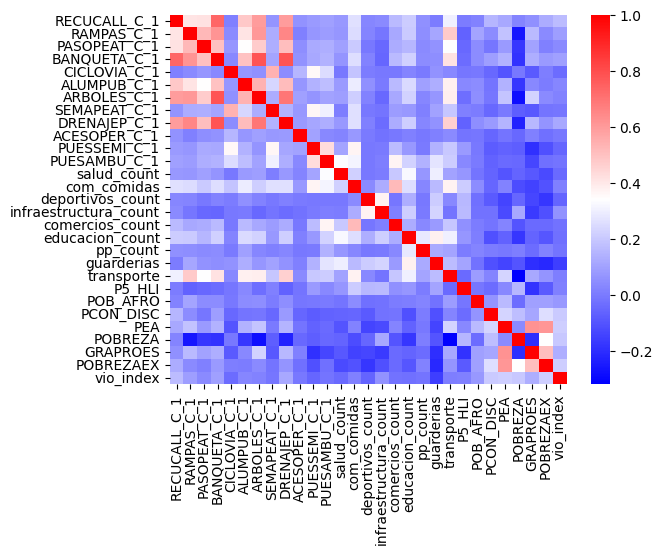

In [46]:
correlation_matrix = data_scaled.corr()

column_names = correlation_matrix.columns

## change commerce feature names

sns.heatmap(correlation_matrix, xticklabels = column_names, yticklabels=column_names, cmap= 'bwr');

In [47]:
#correlation matrix to dataframe
corr_df = correlation_matrix.stack().reset_index()

corr_df.columns = ['feature_1','feature_2','correlation']

no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [48]:
corr_df

,feature_1,feature_2,correlation
1,RECUCALL_C_1,RAMPAS_C_1,0.408387
2,RECUCALL_C_1,PASOPEAT_C_1,0.415446
3,RECUCALL_C_1,BANQUETA_C_1,0.736225
4,RECUCALL_C_1,CICLOVIA_C_1,0.014041
5,RECUCALL_C_1,ALUMPUB_C_1,0.479660
...,...,...,...
835,vio_index,PCON_DISC,0.202702
836,vio_index,PEA,0.214447
837,vio_index,POBREZA,0.197824
838,vio_index,GRAPROES,0.134101


In [49]:
#computing absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

#top 5 most correlated pairs
corr_df.sort_values(by='absolute_correlation', ascending=False).head(30)

,feature_1,feature_2,correlation,absolute_correlation
93,BANQUETA_C_1,ARBOLES_C_1,0.783183,0.783183
177,ARBOLES_C_1,BANQUETA_C_1,0.783183,0.783183
95,BANQUETA_C_1,DRENAJEP_C_1,0.782827,0.782827
235,DRENAJEP_C_1,BANQUETA_C_1,0.782827,0.782827
3,RECUCALL_C_1,BANQUETA_C_1,0.736225,0.736225
87,BANQUETA_C_1,RECUCALL_C_1,0.736225,0.736225
182,ARBOLES_C_1,DRENAJEP_C_1,0.695882,0.695882
238,DRENAJEP_C_1,ARBOLES_C_1,0.695882,0.695882
233,DRENAJEP_C_1,RAMPAS_C_1,0.652937,0.652937
37,RAMPAS_C_1,DRENAJEP_C_1,0.652937,0.652937


In [50]:
## a lot of urban infra are correlated :(

In [51]:
data.shape

(2453, 29)

# **MODEL** | XGBoost

In [52]:
X = data_scaled.drop(columns='vio_index')[22:]
y = data_scaled['vio_index'][22:]

In [53]:
# split into train and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# split tran into X_val and y_val (15%) THIS IS FOR THE XGBOOST MODEL
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 42)

In [54]:
# my_list =  X.columns.tolist()
# duplicates = {num:my_list.count(num) for num in my_list}

# # printing the element with count greater than 1
# for key, value in duplicates.items():
#     if value > 1:
#         print(key, value)

In [55]:
#XGBoost is sensitive to outliers

In [56]:
#instantiate model 
xgb_reg = XGBRegressor(n_estimators = 100 ,max_depth= 5, learning_rate=0.1)


## **Cross validation**

In [57]:
# Cross validation
model = xgb_reg
cv_results = cross_validate(model, X , y, cv=5,
                           scoring=['max_error',
                                   'r2',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_squared_error'])

In [58]:
print('fit time = ', cv_results['fit_time'].mean())
print('score time = ', cv_results['score_time'].mean())

print('MaxE = ', cv_results['test_max_error'].mean())
print('R2 = ',cv_results['test_r2'].mean())
print('RMSE = ',cv_results['test_neg_root_mean_squared_error'].mean())
print('MSE = ',cv_results['test_neg_mean_squared_error'].mean())

fit time =  0.5792636394500732
score time =  0.015845775604248047
MaxE =  -0.5373111177568749
R2 =  0.29838517282190563
RMSE =  -0.10582818291404036
MSE =  -0.011452126620009054


In [59]:
# print(cv_results['test_score'])
# print(cv_results['score_time'])
# cv_results['test_score'].mean()

## **Learning curves**

In [60]:
# #  ?
# train_sizes = [25,50,75,100,250,500,750,1000,1150]

# # Get train scores (R2), train sizes, and validation scores using `learning_curve`
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=xgb_reg, X=X, y=y, train_sizes=train_sizes, cv=5)

# # Take the mean of cross-validated train scores and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

In [61]:
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

## **XGBoost model**

In [62]:
# split tran into X_val and y_val (15%) THIS IS FOR THE XGBOOST MODEL
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X, y, test_size=0.2, random_state = 42)

In [63]:
xgb_reg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [64]:
# import pickle
# file_name = "xgb_reg.pkl"
# # save
# pickle.dump(xgb_reg, open(file_name, "wb"))
# # load
# #xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [65]:
X[32:33]

,RECUCALL_C_1,RAMPAS_C_1,PASOPEAT_C_1,BANQUETA_C_1,CICLOVIA_C_1,ALUMPUB_C_1,ARBOLES_C_1,SEMAPEAT_C_1,DRENAJEP_C_1,ACESOPER_C_1,...,pp_count,guarderias,transporte,P5_HLI,POB_AFRO,PCON_DISC,PEA,POBREZA,GRAPROES,POBREZAEX
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0901000011769,0.592593,0.0,0.0,0.0,0.0,0.074074,0.0,0.0,0.074074,0.0,...,0.0,0.0,0.106481,0.015899,0.01663,0.213721,0.62858,0.4,0.666667,0.5


In [66]:
y_predict = xgb_reg.predict(X[32:33])

print('prediction = ',y_predict)
print('real = ',y[32:33])

prediction =  [0.30738494]
real =  CVEGEO
0901000011769    0.372388
Name: vio_index, dtype: float64


In [67]:
y_predict = xgb_reg.predict(X[53:54])

print('prediction = ',y_predict)
print('real = ',y[53:54])

prediction =  [0.11495651]
real =  CVEGEO
0901000011928    0.081196
Name: vio_index, dtype: float64


In [68]:
# #evaluate the model's performance
# score = xgb_reg.score(X_test, y_test)
# score

In [69]:
# y_pred = xgb_reg.predict(X_val)
# y_pred

## **SHAP**

In [70]:
#creating a SHAP explainer
explainer = shap.Explainer(xgb_reg)

In [71]:
#Calculate the SHAP values
shape_values_01 = explainer(X)
shape_values_02 = explainer(X_test)

In [72]:
y.mean()

np.float64(0.19363922870064038)

In [73]:
y.max()

np.float64(1.0)

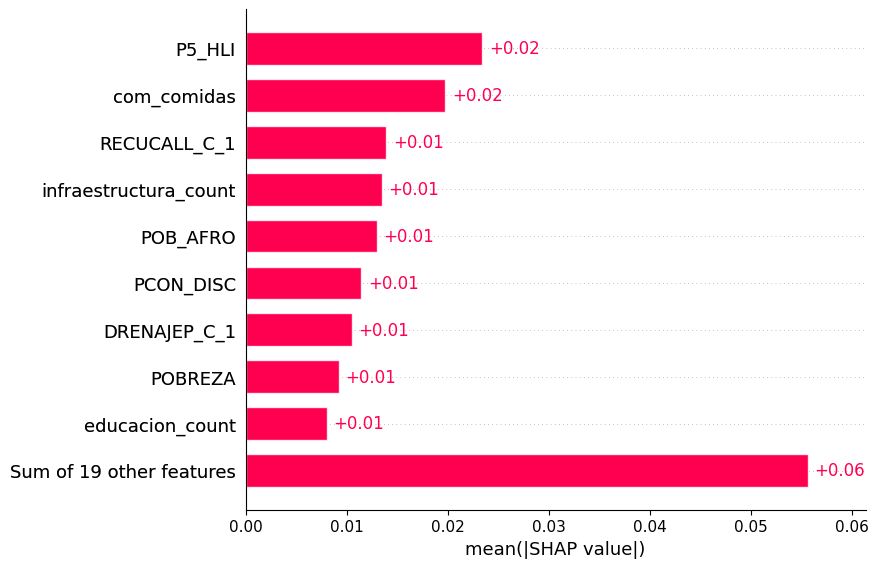

In [74]:
#plot
shap.plots.bar(shape_values_01, max_display=10)

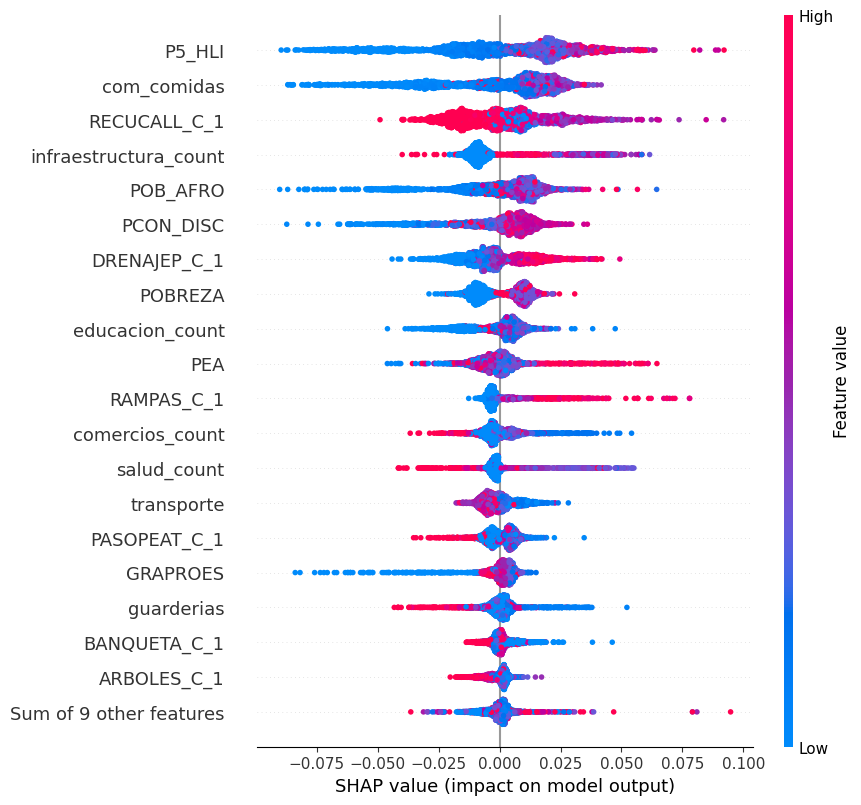

In [75]:
shap.plots.beeswarm(shape_values_01, max_display=20)

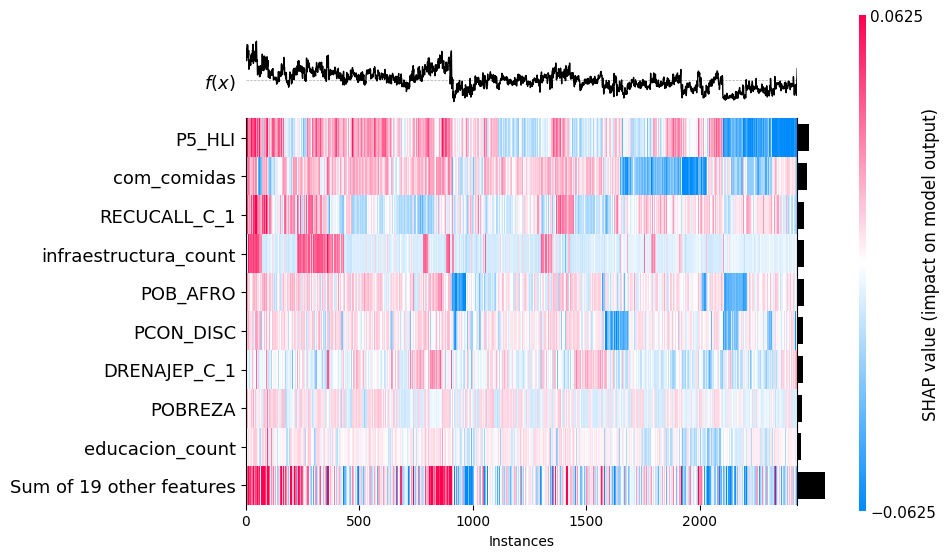

<Axes: xlabel='Instances'>

In [76]:
shap.plots.heatmap(shape_values_01, max_display=10)

# pusheando

In [77]:
! git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Data_exploration.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.python-version
	../clean_datasets/
	.ipynb_checkpoints/
	Data exploration.ipynb
	Data_exploration-Copy1.ipynb
	Data_exploration-posible.ipynb
	Data_exploration_01.ipynb
	GMH_exploracion_data.ipynb
	xgb_reg_mina.pkl

no changes added to commit (use "git add" and/or "git commit -a")


In [78]:
!git add RUS_preprocesing_model.ipynb

!git commit -m 'model to explore'

!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Data_exploration.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.python-version
	../clean_datasets/
	.ipynb_checkpoints/
	Data exploration.ipynb
	Data_exploration-Copy1.ipynb
	Data_exploration-posible.ipynb
	Data_exploration_01.ipynb
	GMH_exploracion_data.ipynb
	xgb_reg_mina.pkl

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


In [79]:
#'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP',
#        'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus', 'VIVTOT',
#        'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7',
#        'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1', 'RAMPAS_C_2',
#        'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 'PASOPEAT_C_1',
#        'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8',
#        'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3',
#        'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 'GUARNICI_C_1',
#        'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8',
#        'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3',
#        'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 'CICLOCAR_C_1',
#        'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9',
#        'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7',
#        'ALUMPUB_C_8', 'ALUMPUB_C_9', 'LETRERO_C_1', 'LETRERO_C_2',
#        'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9',
#        'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7',
#        'ARBOLES_C_8', 'ARBOLES_C_9', 'SEMAPEAT_C_1', 'SEMAPEAT_C_2',
#        'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9',
#        'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7',
#        'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 'ESTABICI_C_1', 'ESTABICI_C_2',
#        'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9',
#        'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7',
#        'DRENAJEP_C_8', 'DRENAJEP_C_9', 'ACESOPER_C_1', 'ACESOPER_C_2',
#        'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8','ACESOPER_C_8', 'ACESOPER_C_9', 'ACESOAUT_C_1', 'ACESOAUT_C_2',
#        'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9',
#        'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7',
#        'PUESSEMI_C_8', 'PUESSEMI_C_9', 'PUESAMBU_C_1', 'PUESAMBU_C_2',
#        'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9',
#        'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14',
#        'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 'P_0A2_F', 'P_3A5_F',
#        'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F',
#        'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M',
#        'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 'P3YM_HLI',
#        'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F',
#        'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND',
#        'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES',
#        'GRAPROES_F', 'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F',
#        'HOGJEF_M', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
#        'com_1', 'com_2', 'com_3', 'com_4', 'com_5', 'com_6', 'com_7', 'com_8',
#        'com_9', 'com_10', 'com_11', 'com_12', 'com_13', 'com_14', 'com_15',
#        'com_16', 'com_17', 'com_18', 'com_19', 'com_19', 'com_20', 'com_21',
#        'com_22', 'com_23', 'com_24', 'com_25', 'com_26', 'com_27', 'com_28', 'com_29',
#        'salud_count', 'deportivos_count', 'infraestructura_count',
#        'comercios_count', 'educacion_count', 'pp_count', 'guarderias']